HW 8 Lecture 9 PCA use cases

Get dataset from Kaggle (any tabular dataset you want)

Make simple classifier / regressor on the dataset

Reasonably reduce dataset dimensionality

Plot explained variance

Explain chosen number of components

Retrain the same classifier / regressor on the dataset with reduced dimensionality

Compare accuracies / MSEs and speed of the two approaches (with and without dimensionality reduction)

Where get ideas for data sets:

https://www.meganstodel.com/posts/no-to-iris/

https://machinelearningmastery.com/standard-machine-learning-datasets/

https://scikit-learn.org/stable/modules/classes.html#loaders

In [85]:
# I use American Citizens Annual Income Data with 2 categories: Annual Income is more than 50k or less?
# https://www.kaggle.com/datasets/amirhosseinmirzaie/americancitizenincome

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier  # You can change the model to your choice
from sklearn.metrics import accuracy_score, mean_squared_error
import time

# Load the dataset into a Pandas DataFrame
df = pd.read_csv("./income.csv", encoding="latin-1")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,United-States,>50K
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,United-States,>50K
4,54,?,148657,Preschool,1,Married-civ-spouse,?,Wife,White,Female,0,0,40,Mexico,<=50K


In [86]:
print("Number of duplicate data : ",df.duplicated().sum())

Number of duplicate data :  12


In [87]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24988 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24988 non-null  int64 
 1   workclass       24988 non-null  object
 2   fnlwgt          24988 non-null  int64 
 3   education       24988 non-null  object
 4   education.num   24988 non-null  int64 
 5   marital.status  24988 non-null  object
 6   occupation      24988 non-null  object
 7   relationship    24988 non-null  object
 8   race            24988 non-null  object
 9   sex             24988 non-null  object
 10  capital.gain    24988 non-null  int64 
 11  capital.loss    24988 non-null  int64 
 12  hours.per.week  24988 non-null  int64 
 13  native.country  24988 non-null  object
 14  income          24988 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.1+ MB


In [88]:
df.nunique()

age                  73
workclass             9
fnlwgt            17876
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        117
capital.loss         90
hours.per.week       93
native.country       41
income                2
dtype: int64

In [89]:
df = df.drop(columns=['education']) # education and education.num represent the same
df = df.replace('?', np.NaN) #  Replace "?" with np.NAN to detect missing values

missing_counts = df.isnull().sum()
fig = go.Figure(data=[go.Bar(x=missing_counts.index, y=missing_counts.values)])
fig.update_layout(title_text='Missing Value Counts',
                  xaxis_title='Columns',
                  yaxis_title='Missing Value Count')
fig.show()

Data cleaning

In [90]:
columns_to_encode = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country','income']
for column in columns_to_encode:
    df[column] = pd.Categorical(df[column]).codes
df.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,40,5,223881,15,2,9,0,4,1,99999,0,70,37,1
1,30,3,149118,9,0,2,1,4,0,0,0,40,37,0
2,46,3,109209,10,2,0,0,4,1,0,0,40,37,1
3,32,3,229566,11,2,7,0,4,1,0,0,60,37,1
4,54,-1,148657,1,2,-1,5,4,0,0,0,40,24,0


  Replace missing values with the most frequent value 

In [91]:
cols = ['workclass', 'occupation', 'native.country']

for col in cols:
    most_frequent = df[col].value_counts().sort_values(ascending=False).index[0]
    df[col].fillna(most_frequent, inplace=True)
    print('All the missing values in column', col, 'are replaced with', most_frequent)

All the missing values in column workclass are replaced with 3
All the missing values in column occupation are replaced with 9
All the missing values in column native.country are replaced with 37


Box plot for numreical values and detecting outliers 

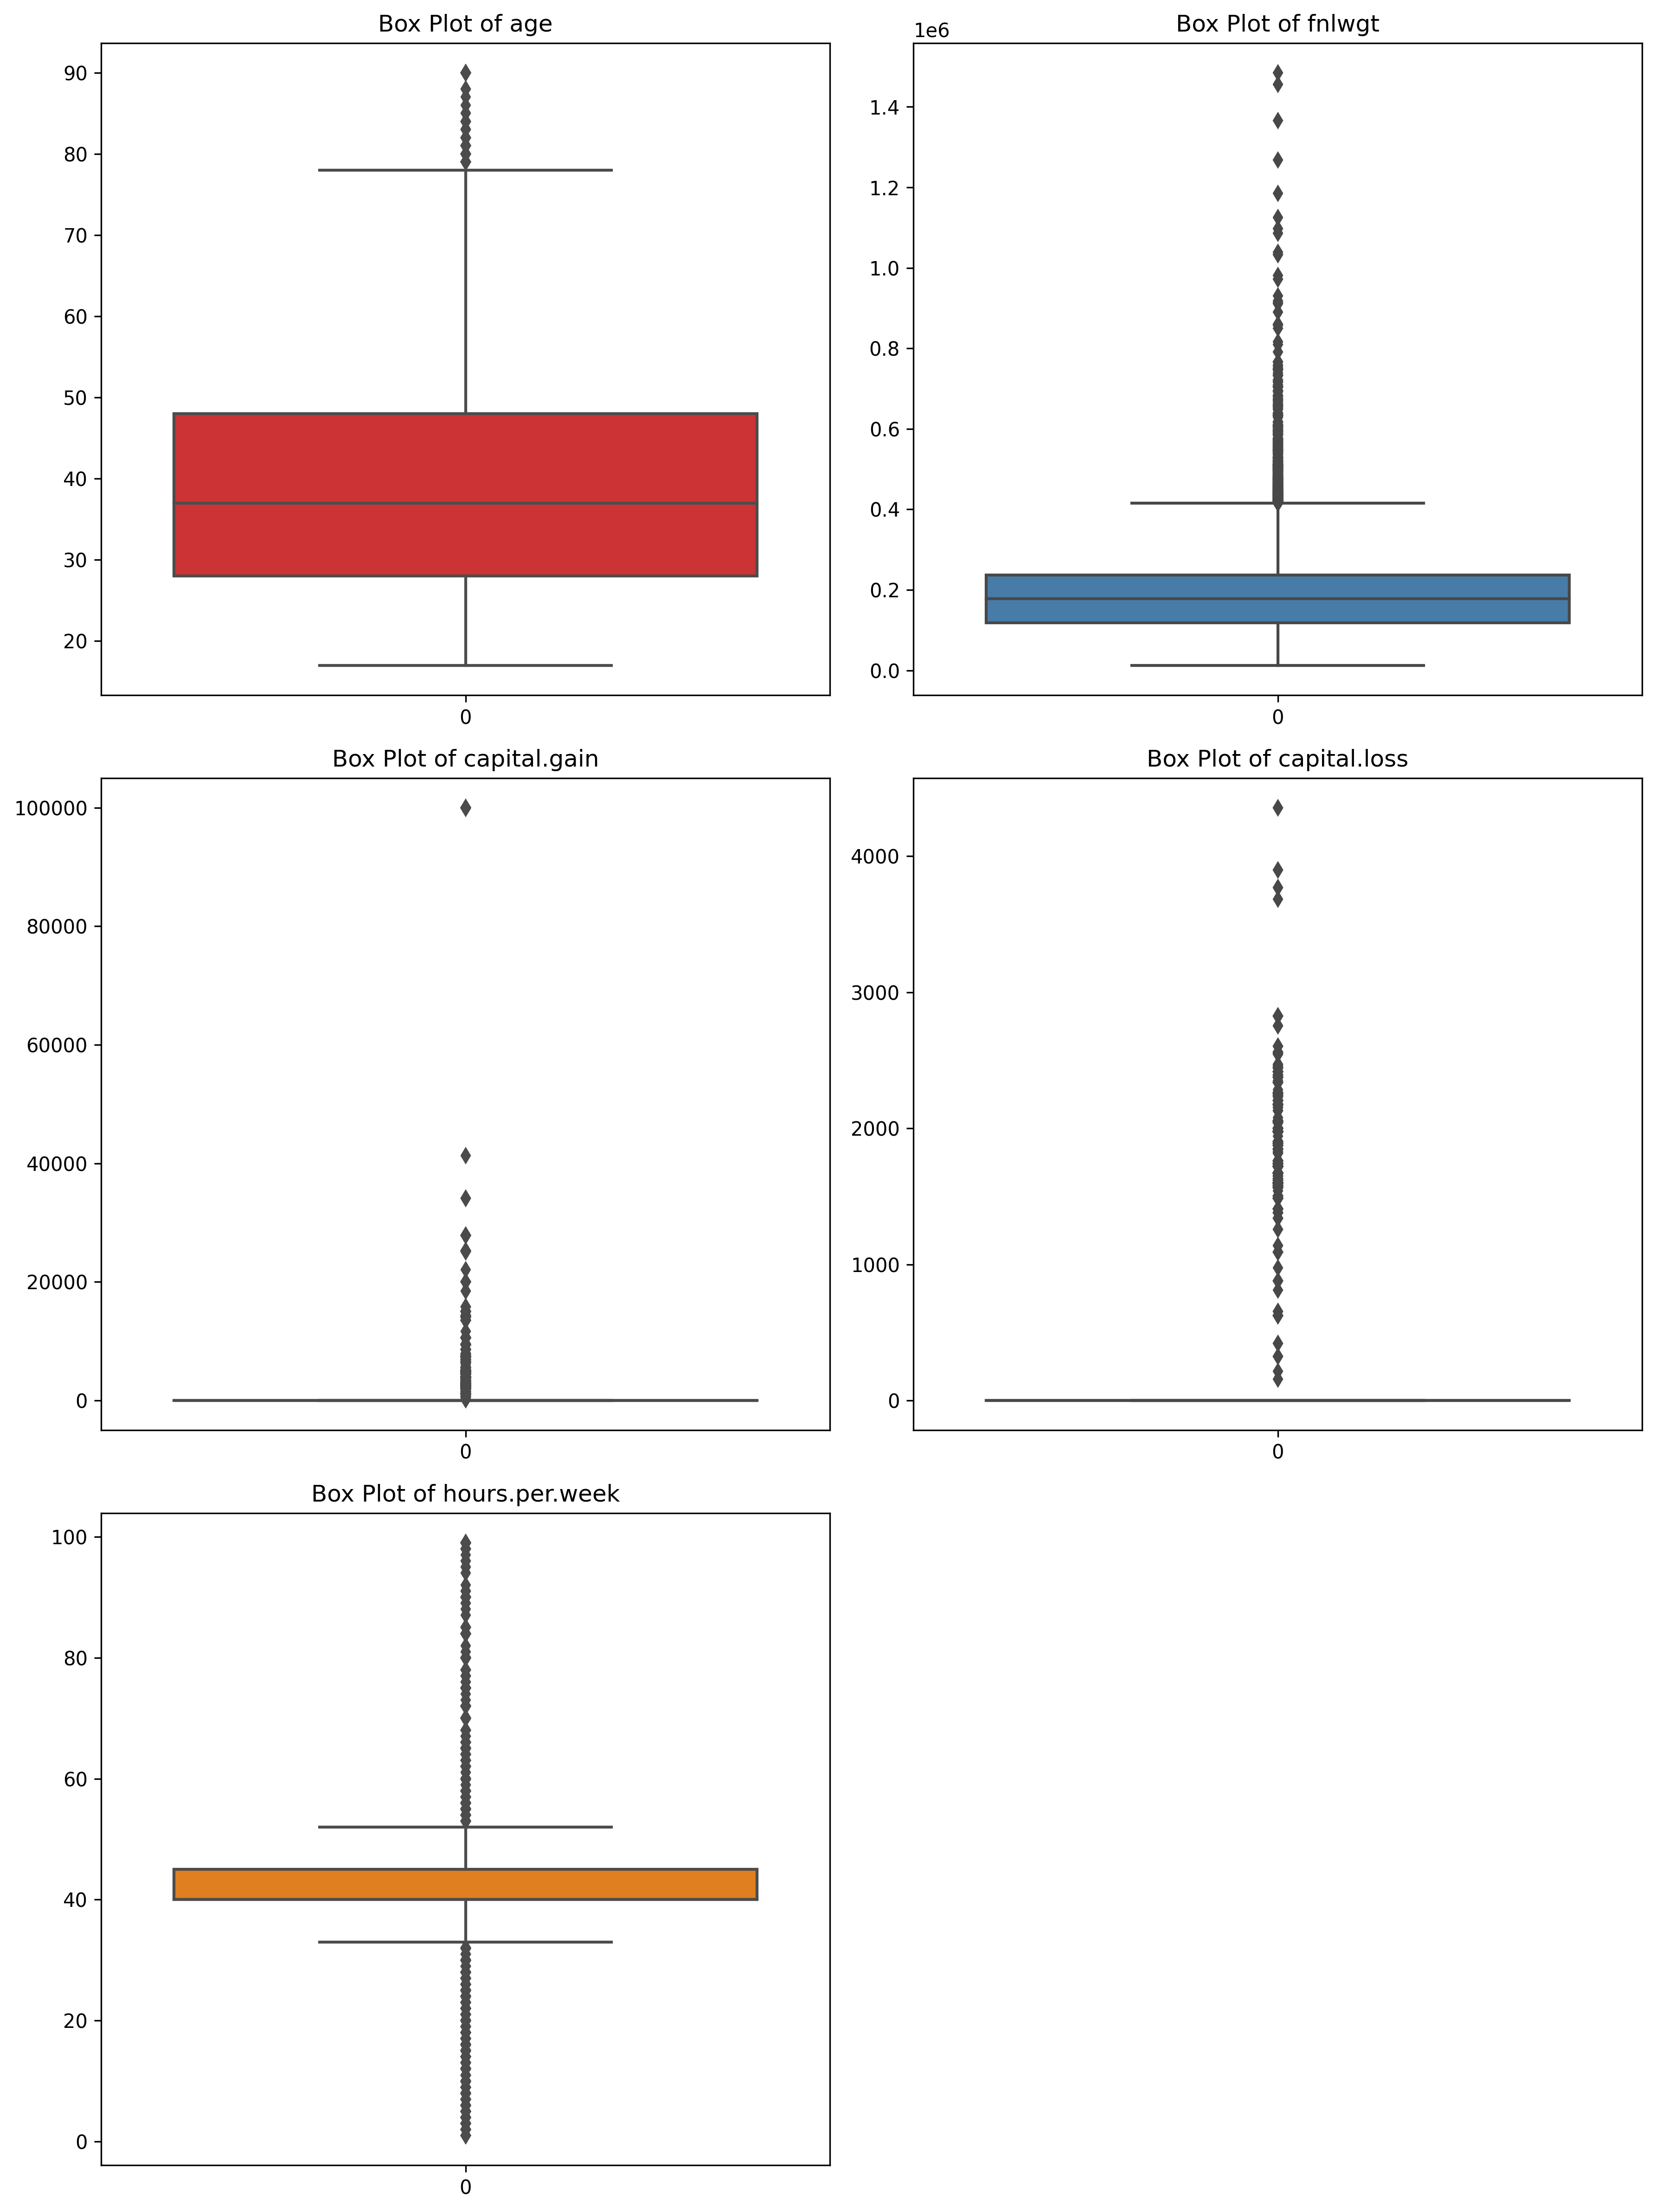

In [92]:
column_to_exclude = ['sex', 'workclass', 'education.num', 'marital.status', 'occupation', 'race', 'relationship', 'income', 'native.country']

all_columns = df.columns

columns = all_columns.drop(column_to_exclude).values

num_columns = len(columns)
num_rows = (num_columns + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 16),dpi = 300)

colors = sns.color_palette("Set1", num_columns)
for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.boxplot(data=df[column], ax=axes[row, col], color=colors[i])
    axes[row, col].set_title(f'Box Plot of {column}')

if num_columns % 2 != 0:
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.show()

In [93]:
df = df[(df['capital.gain']<50000) & (df['capital.loss'] < 3000)] # remove outliers

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24862 entries, 1 to 24999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             24862 non-null  int64
 1   workclass       24862 non-null  int8 
 2   fnlwgt          24862 non-null  int64
 3   education.num   24862 non-null  int64
 4   marital.status  24862 non-null  int8 
 5   occupation      24862 non-null  int8 
 6   relationship    24862 non-null  int8 
 7   race            24862 non-null  int8 
 8   sex             24862 non-null  int8 
 9   capital.gain    24862 non-null  int64
 10  capital.loss    24862 non-null  int64
 11  hours.per.week  24862 non-null  int64
 12  native.country  24862 non-null  int8 
 13  income          24862 non-null  int8 
dtypes: int64(6), int8(8)
memory usage: 1.5 MB


In [95]:
X = df.drop(['income'], axis=1).values
X.shape

(24862, 13)

In [96]:
y = df['income'].values
y.shape

(24862,)

In [97]:
from sklearn.metrics import roc_auc_score
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=5)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
roc_auc_score(y_test, y_pred)

/Users/mac/Documents/ML/L09/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/mac/Documents/ML/L09/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Use

0.6282289739441663

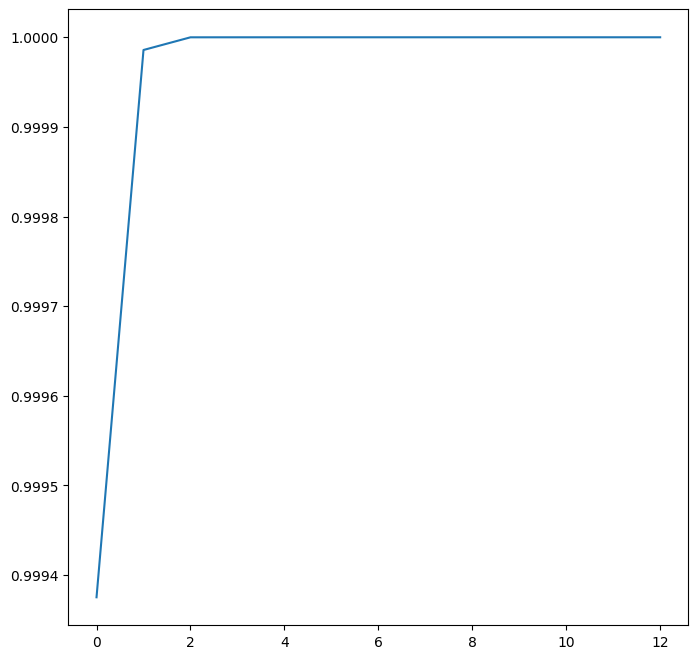

In [98]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,8))
plt.plot(cumsum)

In [99]:
pca = PCA(n_components=7)
x_train_pca = pca.fit_transform(x_train)

lr = LogisticRegressionCV(cv=5)
lr.fit(x_train_pca, y_train)
y_pred = lr.predict(pca.transform(x_test))
roc_auc_score(y_test, y_pred)

/Users/mac/Documents/ML/L09/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.6607751305175118

 Since we have unbalance dataset with 75% of low income people, let's increase the number of high income values to make our data balanced 

In [100]:
px.pie(df, names='income', title='Income', color_discrete_sequence=px.colors.qualitative.G10)

In [112]:
X = df.drop('income',axis=1)
y = df['income']

In [113]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

x_balanced, y_balanced = smote.fit_resample(X, y)
print(y_balanced.value_counts())

income
0    18937
1    18937
Name: count, dtype: int64


In [114]:
df_balanced = pd.concat([x_balanced, y_balanced], axis=1)
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37874 entries, 0 to 37873
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             37874 non-null  int64
 1   workclass       37874 non-null  int8 
 2   fnlwgt          37874 non-null  int64
 3   education.num   37874 non-null  int64
 4   marital.status  37874 non-null  int8 
 5   occupation      37874 non-null  int8 
 6   relationship    37874 non-null  int8 
 7   race            37874 non-null  int8 
 8   sex             37874 non-null  int8 
 9   capital.gain    37874 non-null  int64
 10  capital.loss    37874 non-null  int64
 11  hours.per.week  37874 non-null  int64
 12  native.country  37874 non-null  int8 
 13  income          37874 non-null  int8 
dtypes: int64(6), int8(8)
memory usage: 2.0 MB


In [115]:
x_balanced = df_balanced.drop(columns=['income'], axis=1)
y_balanced = df_balanced['income']

In [116]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
lr = LogisticRegressionCV(cv=5)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
roc_auc_score(y_test, y_pred)

/Users/mac/Documents/ML/L09/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/mac/Documents/ML/L09/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Use

0.7156254345140214

So, we see the making the dataset to be balanced increase the predicted power even of a simple logistic regression.

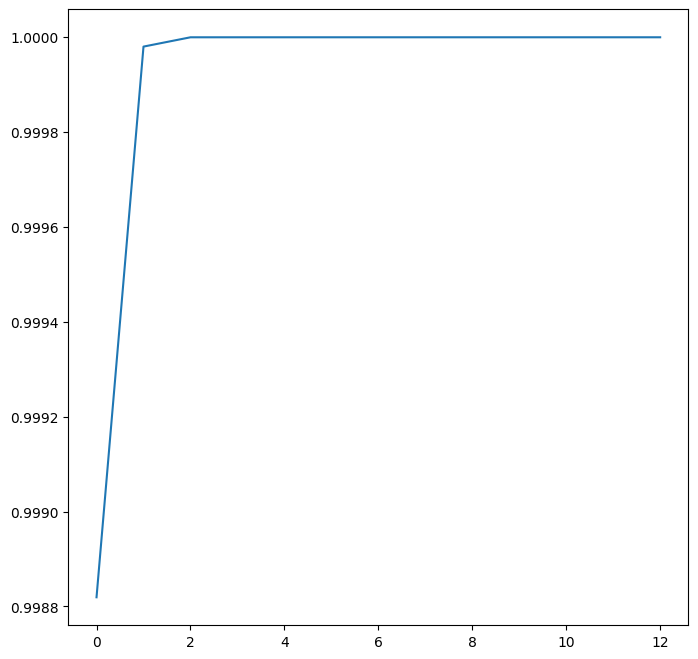

In [117]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,8))
plt.plot(cumsum)

In [131]:
pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(x_train)

lr = LogisticRegressionCV(cv=5)
lr.fit(x_train_pca, y_train)
y_pred = lr.predict(pca.transform(x_test))
roc_auc_score(y_test, y_pred)

/Users/mac/Documents/ML/L09/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/mac/Documents/ML/L09/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Use

0.7298310881437449

Explain chosen number of components: since the plotted variance is close to 1 even for 2 components, I've tried manually increasing the number of components. The "best fit" (sharp enough increase in ROC) was for 7 components for unbalanced dataset and 10 for balanced data.  Since, the number of components is large relatively to the whole dataset, the time is almost the same

Probably, I've chosen not the best dataset for PCA, since income group depends on a number of characteristics. Moreover, simple logistic regression doesn't fit as good as the random forest.